In [1]:
# checking GPU connections
!nvidia-smi

Thu Aug 29 20:05:53 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import os
HOME = os.getcwd() ##Creating HOME constant to manage data
print(HOME)

/content


## Installing required packages

In [3]:
## inference, for executing zero-shot object detection using YOLO-World
!pip install -q inference-gpu[yolo-world]==0.9.12rc1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.0/301.0 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.6/318.6 kB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 45.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.1/148.1 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 746.9/746.9 kB 34.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.9/45.9 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 49.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 kB 6.1 MB/s eta 0:00:00
   ━━━━

In [4]:
## supervision, for post-processing and visualizing the detected objects.

!pip install -q supervision==0.19.0rc3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.8/90.8 kB 4.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inference-sdk 0.16.3 requires supervision<1.0.0,>=0.20.0, but you have supervision 0.19.0rc3 which is incompatible.


## Imports

In [10]:
import cv2
import supervision as sv

from tqdm import tqdm
from inference.models.yolo_world.yolo_world import YOLOWorld

import os
import numpy as np
import matplotlib.pyplot as plt

In [6]:
data_path = "/content/drive/MyDrive/data/car-od-data-unlabelled"

### Viewing first 10 images

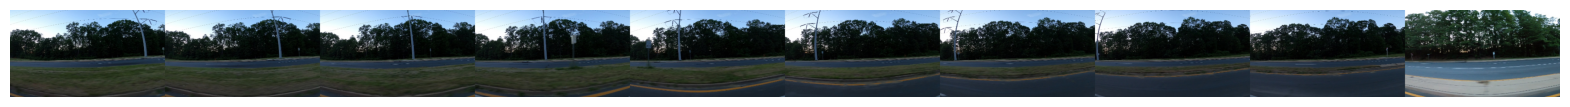

In [11]:
# Get all image file names
image_files = sorted([f for f in os.listdir(data_path) if f.endswith(('.png', '.jpg', '.jpeg'))])

# Select the first 10 images
first_10_images = image_files[:10]

# Load the images
images = []
for img_file in first_10_images:
    img = cv2.imread(os.path.join(data_path, img_file))
    images.append(img)

# Resize images to the same height (optional)
height = 200  # desired height for all images
resized_images = [cv2.resize(img, (int(img.shape[1] * height / img.shape[0]), height)) for img in images]

# Concatenate images horizontally
concatenated_image = np.hstack(resized_images)

# Convert BGR (OpenCV format) to RGB (matplotlib format)
concatenated_image_rgb = cv2.cvtColor(concatenated_image, cv2.COLOR_BGR2RGB)

# Display the concatenated image using matplotlib
plt.figure(figsize=(20, 10))
plt.imshow(concatenated_image_rgb)
plt.axis('off')  # Hide the axes
plt.show()

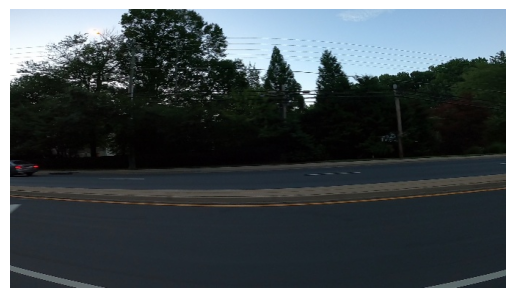

In [12]:
img_100th = cv2.imread(os.path.join(data_path, image_files[99]))
img_rgb = cv2.cvtColor(img_100th, cv2.COLOR_BGR2RGB)

plt.imshow(img_rgb)
plt.axis('off')  # Hide the axes
plt.show()

## YOLO-WORLD Object detection model

In [13]:
model = YOLOWorld(model_id="yolo_world/l")

Defining a prompt as list of classes that are of interest. YOLO-World is a zero-shot model, enabling object detection without any training.

In [14]:
classes =  ["car"]
model.set_classes(classes)

100%|███████████████████████████████████████| 338M/338M [00:07<00:00, 50.5MiB/s]


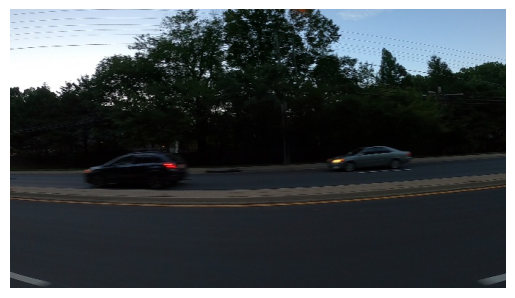

In [18]:
sample_img = cv2.imread(os.path.join(data_path, image_files[97]))
img_rgb = cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB)

plt.imshow(img_rgb)
plt.axis('off')  # Hide the axes
plt.show()

### Checking up model with sample image

In [28]:
sample_img = cv2.imread(os.path.join(data_path, image_files[97]))
results = model.infer(sample_img, confidence = 0.003) ## adjusted thresold
detections = sv.Detections.from_inference(results).with_nms(threshold = 0.1) ##To eliminate duplicates, we will use Non-Max Suppression (NMS). NMS evaluates the extent to which detections overlap using the Intersection over Union metric and, upon exceeding a defined threshold, treats them as duplicates. Duplicates are then discarded, starting with those of the lowest confidence. The value should be within the range [0, 1]. The smaller the value, the more restrictive the NMS.

Adjust bounding box properties using supervision

In [29]:
BOUNDING_BOX_ANNOTATOR = sv.BoundingBoxAnnotator(thickness=2)
LABEL_ANNOTATOR = sv.LabelAnnotator(text_thickness=2, text_scale=1, text_color=sv.Color.BLACK)

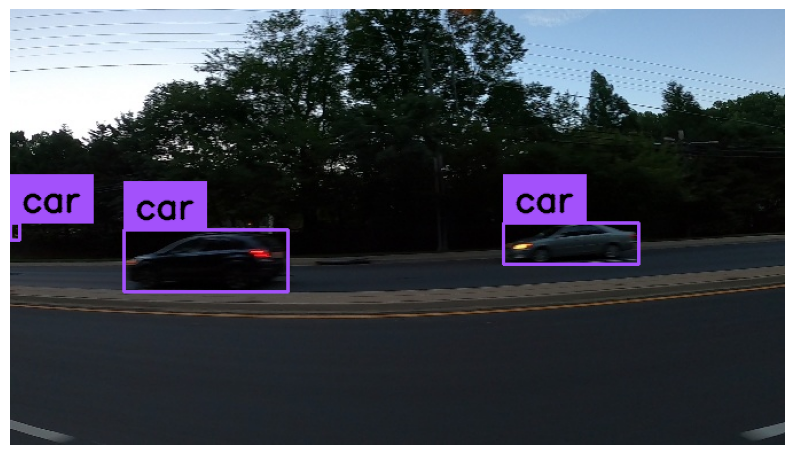

In [30]:
labels = [
    f"{classes[class_id]} {confidence:0.3f}"
    for class_id, confidence
    in zip(detections.class_id, detections.confidence)
]

annotated_image = sample_img.copy()
annotated_image = BOUNDING_BOX_ANNOTATOR.annotate(annotated_image, detections)
annotated_image = LABEL_ANNOTATOR.annotate(annotated_image, detections)
sv.plot_image(annotated_image, (10, 10))

### Now, performing OD on all the images in the dataset

In [31]:
# Get all image file names
image_files = sorted([f for f in os.listdir(data_path) if f.endswith(('.png', '.jpg', '.jpeg'))])

# Loop through all images
for img_file in tqdm(image_files):  # tqdm gives you a progress bar
    # Load the image
    sample_img = cv2.imread(os.path.join(data_path, img_file))

    # Perform object detection (replace this with your model inference)
    results = model.infer(sample_img, confidence=0.003)  # Adjusted threshold

    # Apply non-maximum suppression (NMS) and get detections
    detections = sv.Detections.from_inference(results).with_nms(threshold=0.1)

    # Create labels for detected objects
    labels = [
        f"{classes[class_id]} {confidence:0.3f}"
        for class_id, confidence
        in zip(detections.class_id, detections.confidence)
    ]

    # Annotate the image with bounding boxes and labels
    annotated_image = sample_img.copy()
    annotated_image = BOUNDING_BOX_ANNOTATOR.annotate(annotated_image, detections)
    annotated_image = LABEL_ANNOTATOR.annotate(annotated_image, detections)

    # Save the annotated image to a folder
    output_path = "/content/drive/MyDrive/data/annotated_images"
    os.makedirs(output_path, exist_ok=True)  # Create the folder if it doesn't exist
    output_file = os.path.join(output_path, f"annotated_{img_file}")

    cv2.imwrite(output_file, annotated_image)  # Save the annotated image

    # Optionally, display the annotated image (comment out if not needed)
    # sv.plot_image(annotated_image, (10, 10))

print("Object detection completed for all images.")


100%|██████████| 175/175 [00:10<00:00, 16.23it/s]

Object detection completed for all images.


In [34]:
# Path to the folder where the annotated images are saved
output_path = "/content/drive/MyDrive/data/annotated_images"

# Get all annotated image file names
annotated_images = sorted([f for f in os.listdir(output_path) if f.endswith(('.png', '.jpg', '.jpeg'))])

# View each annotated image
for img_file in annotated_images:
    # Load the image
    img = cv2.imread(os.path.join(output_path, img_file))

    # Convert BGR (OpenCV format) to RGB (matplotlib format)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Display the image using matplotlib
    plt.figure(figsize=(10, 10))
    plt.imshow(img_rgb)
    plt.axis('off')  # Hide the axes
    plt.show()


Output hidden; open in https://colab.research.google.com to view.